In [99]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

Read the csv files, drop duplicate rows and visualise each csv file

In [100]:
# Get a list of all CSV files in the data folder
data_folder = 'data'
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
# Loop through the CSV files

dataframes = []
for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(data_folder, csv_file), sep=";")
        
        # Drop duplicate rows
        df = df.drop_duplicates()
        dataframes.append(df)

def visualize_dfs(dataframes):
    for df in dataframes:
        # Visualize the data
        df.hist(figsize=(10, 10))
        plt.show()

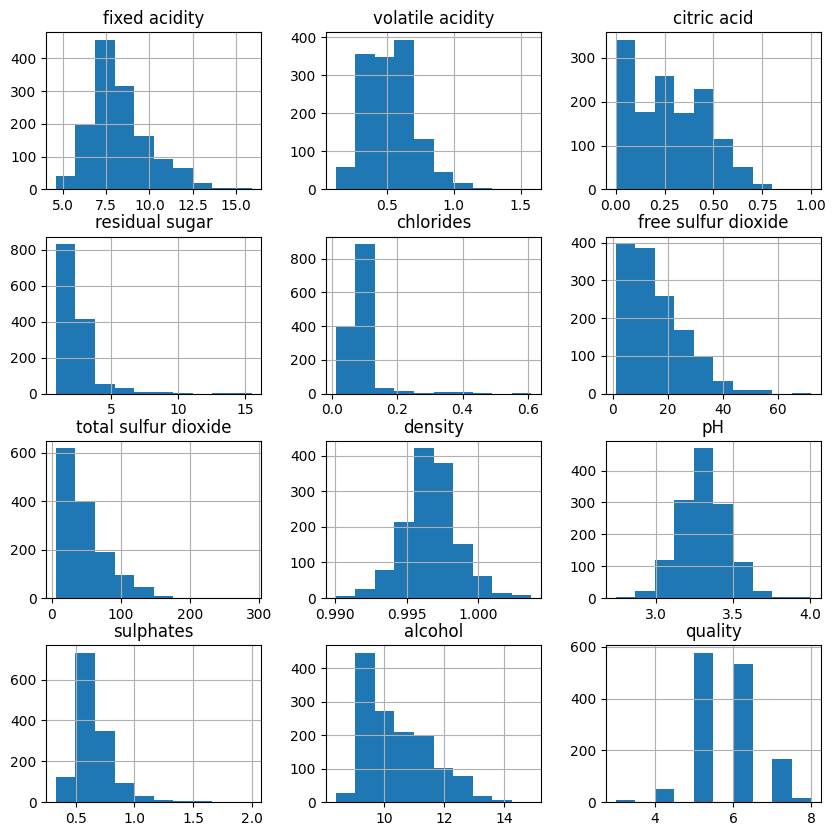

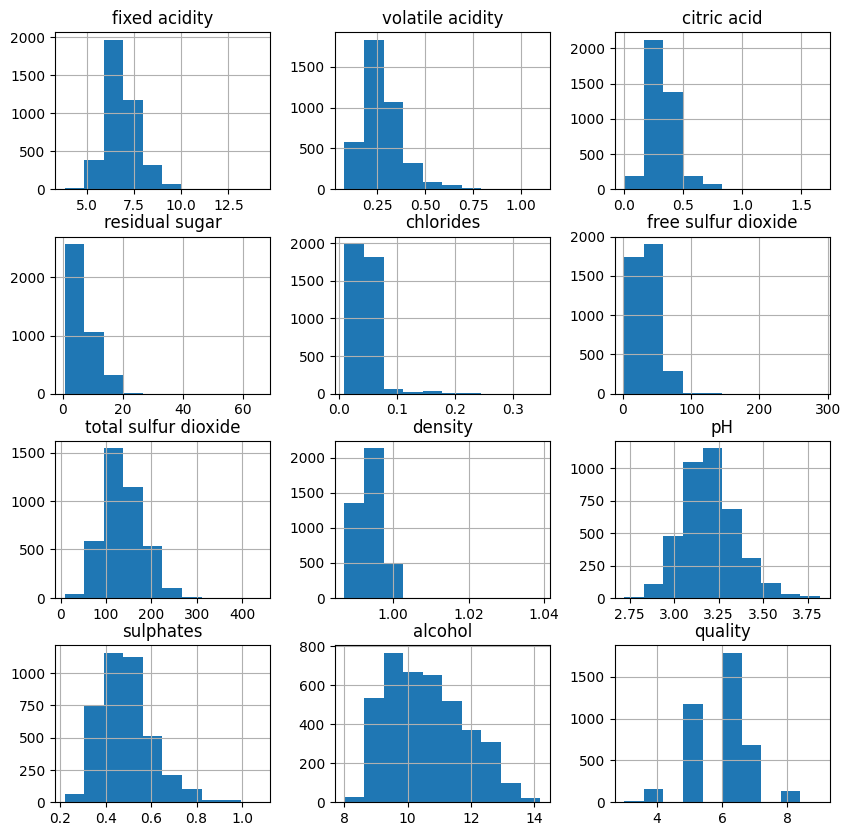

In [101]:
visualize_dfs(dataframes)

In [102]:
from collections import Counter

print(Counter(dataframes[0].quality))

Counter({5: 577, 6: 535, 7: 167, 4: 53, 8: 17, 3: 10})


We see that there is not a good spread in the qualities. Some qualities are less represented than others. An idea is to create our own quality numeration, say 1-4, and choose which qualities from the old quality ratings to be in the new quality rating 1, 2, and so on. What we will do is the following:

quality 3 + 4 --> quality 1
quality 5 --> quality 2
quality 6 --> quality 3
quality 7 + 8 --> quality 4

Even though there is still an imbalance, the representation of each quality class i better than in the previous case, and something we can work with

In [103]:
for df in dataframes:
    df.loc[df.quality < 5, 'quality'] = 1
    df.loc[df.quality == 5, 'quality'] = 2
    df.loc[df.quality == 6, 'quality'] = 3
    df.loc[df.quality > 6, 'quality'] = 4
    


Counter({2: 577, 3: 535, 4: 184, 1: 63})


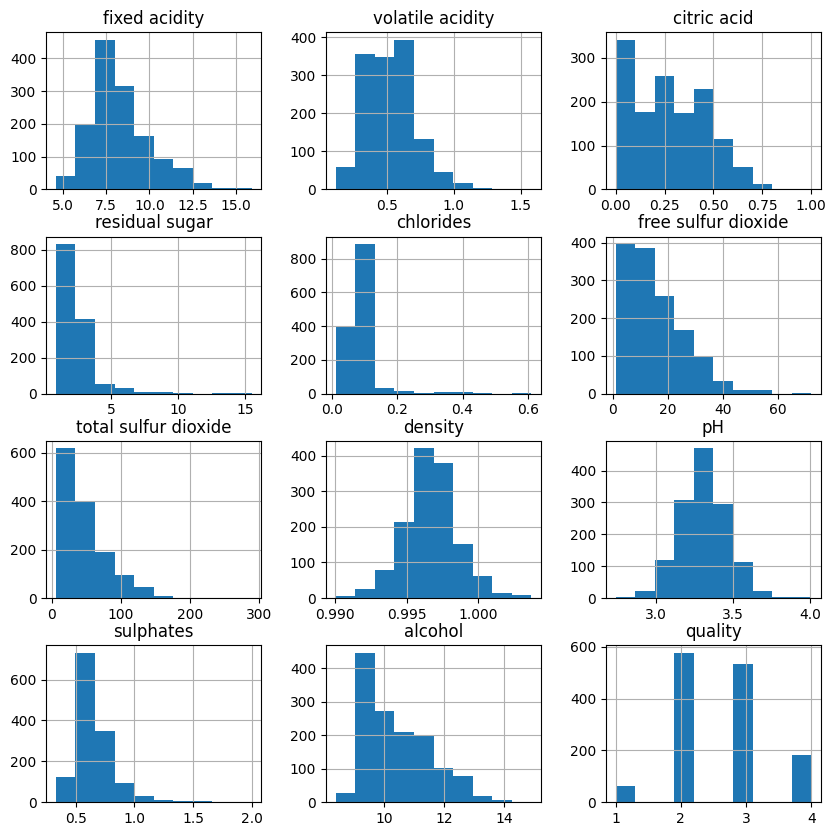

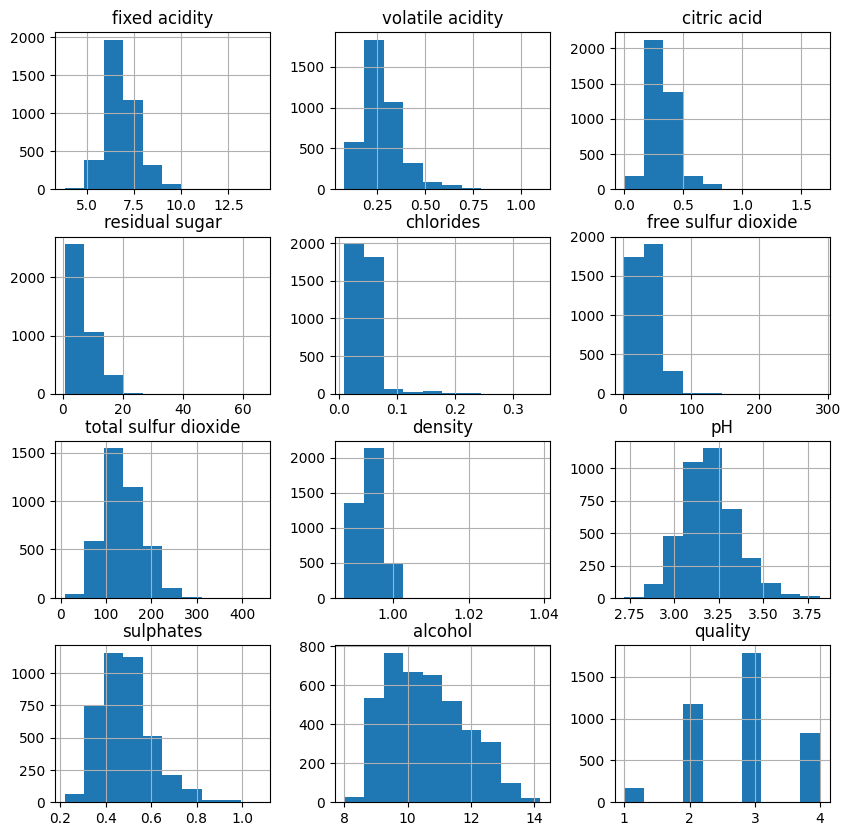

In [104]:
print(Counter(dataframes[0].quality))
visualize_dfs(dataframes)


Trial was made when keeping the qualities as they were given. Though the results are slightly unfair as the 10% test data split gave the quality 3 class 9 samples out of 1223, meaning that it had poor representation. This means that the model will be biased towards the other classes. Hence, ultimately we go with this method.

Although not perfect, we now have slightly better spread in quality. The lowest quality in this case, 1, is better represented than the lowest quality in the previous data, 3, which only had 10 cases. 

Now, we will investigate which features have significance when we want to predict the wine quality. We also take notice in the fact that some features represent the same feature characteristic, so we will try to avoid using multiple versions of the same feature. We pic out all features with permutation importance greater than 0.01.

# Red wine

In [107]:
def feature_importance(dataframe, title, threshold=0.015):
    X, y = dataframe.drop('quality', axis=1), dataframe['quality']
    y = pd.DataFrame(y, columns=['quality'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10, stratify=y)
    clf = RandomForestClassifier(n_estimators=500)
    clf.fit(X_train, y_train)

    perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=20, random_state=10,  n_jobs=-1)

    indices = np.where(perm_importance.importances_mean >= threshold)[0]
    perm_importance = pd.DataFrame(data = perm_importance.importances_mean[indices], index=X.columns[indices], columns=['importance'])
    perm_importance.sort_values(by='importance', ascending=False, inplace=True)
    perm_importance.plot(kind='barh', figsize=(10, 10), title=title)
    plt.show()
    return perm_importance
        

/tmp/ipykernel_64839/231031061.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


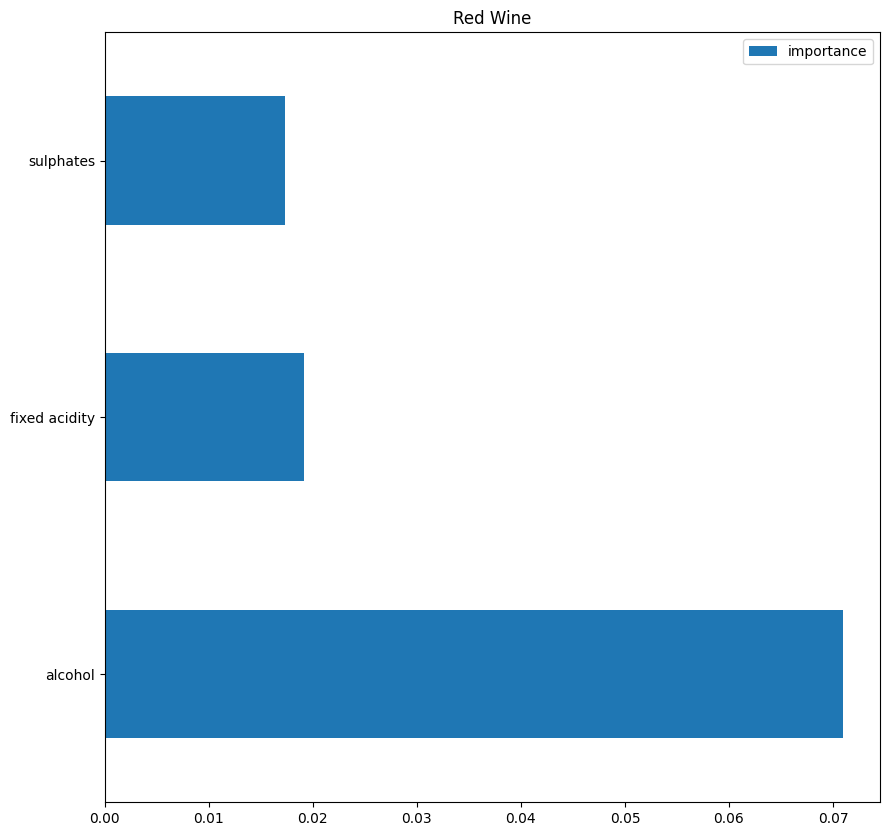

/tmp/ipykernel_64839/231031061.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


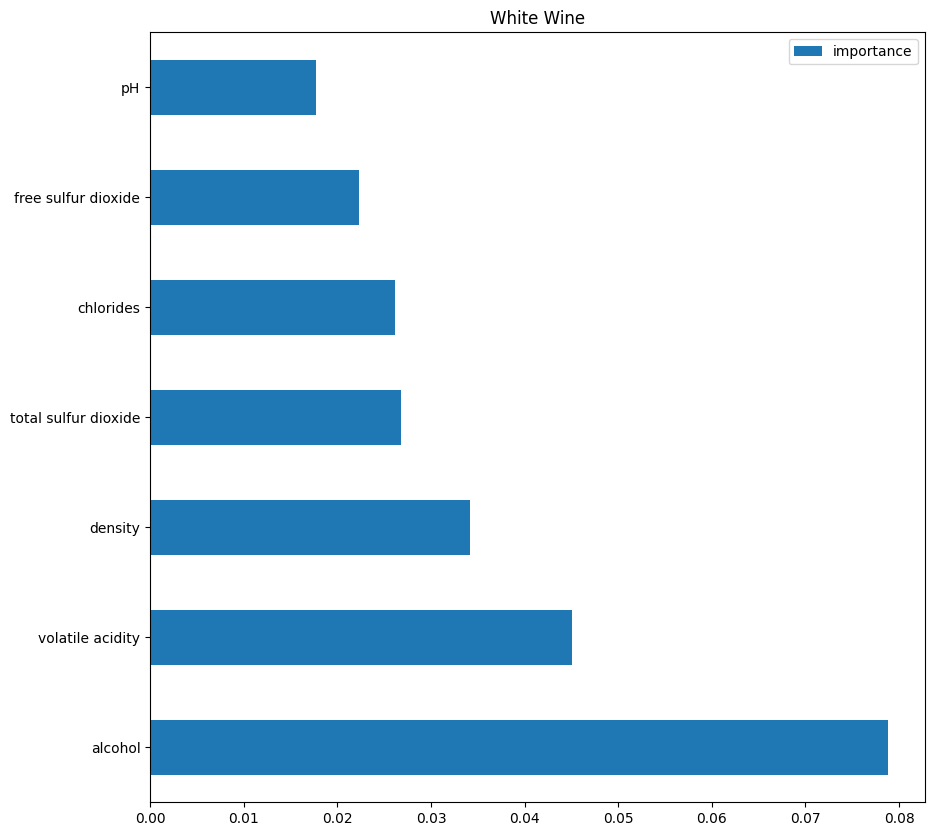

In [108]:
red_whine_importance = feature_importance(dataframes[0], 'Red Wine', threshold=0.01)
white_whine_importance = feature_importance(dataframes[1], 'White Wine', threshold=0.01)

In [ ]:
#find common features
common_features = set(red_whine_importance.index).intersection(set(white_whine_importance.index))
print(common_features)

{'alcohol', 'fixed acidity', 'sulphates'}


Based on the threshold 0.015, we pick out the following common important features:

- alcohol
- fixed acidity
- sulphates

Besides these we will also pick features that appear with high importance, these are:
- denisty 
- total sulfur dioxide
- (volatile acidity, will not be included since we already use fixed acidity which is similar)



In [109]:
X, y = dataframes[0].drop('quality', axis=1), dataframes[0]['quality']
y = pd.DataFrame(y, columns=['quality'])

#Only keep features: alchohol, volatile acidity, sulphates, density, and total sulfur dioxide
X = X[['alcohol', 'volatile acidity', 'sulphates', 'density', 'total sulfur dioxide']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10, stratify=y)

# random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=10)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print('Random Forest Classifier confusion matrix:')
print(classification_report(y_test, rfc_pred))
print('Random Forest Classifier accuracy:')
print(accuracy_score(y_test, rfc_pred))

# gradient boosting classifier
gbc = GradientBoostingClassifier(n_estimators=100, random_state=10)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
print('Gradient Boosting Classifier confusion matrix:')
print(classification_report(y_test, gbc_pred))
print('Gradient Boosting Classifier accuracy:')
print(accuracy_score(y_test, gbc_pred))

# logistic regression
lr = LogisticRegression(random_state=10)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print('Logistic Regression confusion matrix:')
print(classification_report(y_test, lr_pred))
print('Logistic Regression accuracy:')
print(accuracy_score(y_test, lr_pred))

# support vector machine
svm = SVC(random_state=10)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print('Support Vector Machine confusion matrix:')
print(classification_report(y_test, svm_pred))
print('Support Vector Machine accuracy:')
print(accuracy_score(y_test, svm_pred))

# k-nearest neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('K-Nearest Neighbors confusion matrix:')
print(classification_report(y_test, knn_pred))
print('K-Nearest Neighbors accuracy:')
print(accuracy_score(y_test, knn_pred))




/tmp/ipykernel_64839/3881141337.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Random Forest Classifier confusion matrix:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.66      0.72      0.69        58
           3       0.52      0.52      0.52        54
           4       0.50      0.50      0.50        18

    accuracy                           0.58       136
   macro avg       0.42      0.44      0.43       136
weighted avg       0.55      0.58      0.57       136

Random Forest Classifier accuracy:
0.5808823529411765


/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Gradient Boosting Classifier confusion matrix:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.64      0.67      0.66        58
           3       0.46      0.46      0.46        54
           4       0.45      0.50      0.47        18

    accuracy                           0.54       136
   macro avg       0.39      0.41      0.40       136
weighted avg       0.52      0.54      0.53       136

Gradient Boosting Classifier accuracy:
0.5367647058823529
Logistic Regression confusion matrix:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.71      0.79      0.75        58
           3       0.55      0.59      0.57        54
           4       0.38      0.28      0.32        18

    accuracy                           0.61       136
   macro avg       0.41      0.42      0.41       136
weighted avg       0.57      0.61      0.5

/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/farhad/anaconda3/envs/ID2223/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being s

Best results were achieved with Logistic Regression, so the training algorithm will use this model architecture.